# Model Training for Charpy Energy Prediction

This notebook trains multiple regression models on PCA-transformed data and compares their performance using GridSearchCV with 5-fold cross-validation.

**Charpy Energy (J)** measures impact toughness - the energy absorbed by a welded specimen during fracture under impact loading. It's a critical quality indicator for structural applications requiring high toughness, especially in low-temperature or dynamic loading environments.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import joblib
import os 

In [18]:
os.makedirs('trained_models', exist_ok=True)

In [ ]:
df = pd.read_csv('data/welddb_pca_charpy_energy.csv')
print(f"Dataset shape: {df.shape}")

Dataset shape: (879, 15)


In [20]:
X = df.drop('Charpy_Energy_J', axis=1)
y = df['Charpy_Energy_J']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 703
Testing samples: 176


## Model Definitions

**Strategy**: Test multiple regression models with simple hyperparameter grids for faster training.

In [21]:
from sklearn.linear_model import LinearRegression

models = {
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(),
    'LassoRegression': Lasso(),
    'ElasticNetRegression': ElasticNet(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

In [22]:
# Définir les grilles de recherche d'hyperparamètres pour GridSearch
param_grids = {
    'LinearRegression': {},
    'RidgeRegression': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'LassoRegression': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'ElasticNetRegression': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'DecisionTreeRegressor': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 10, 20]},
    'RandomForestRegressor': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'GradientBoostingRegressor': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']} 
}

## Train Models with GridSearchCV

In [23]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'Model': name,
        'Best_Params': str(grid_search.best_params_),
        'CV_Score': grid_search.best_score_,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse
    })
    
    joblib.dump(grid_search.best_estimator_, f'trained_models/{name}_model.pkl')
    
    print(f"  CV R²: {grid_search.best_score_:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Train R²: {train_r2:.4f}")
    print()

Training LinearRegression...
  CV R²: 0.1188
  Test R²: 0.2001
  Train R²: 0.1767

Training RidgeRegression...
  CV R²: 0.1230
  Test R²: 0.1936
  Train R²: 0.1737

Training LassoRegression...
  CV R²: 0.0782
  Test R²: 0.1150
  Train R²: 0.1138

Training ElasticNetRegression...
  CV R²: 0.1188
  Test R²: 0.2001
  Train R²: 0.1767

Training RidgeRegression...
  CV R²: 0.1230
  Test R²: 0.1936
  Train R²: 0.1737

Training LassoRegression...
  CV R²: 0.0782
  Test R²: 0.1150
  Train R²: 0.1138

Training ElasticNetRegression...
  CV R²: 0.1176
  Test R²: 0.1828
  Train R²: 0.1683

Training DecisionTreeRegressor...
  CV R²: 0.1176
  Test R²: 0.1828
  Train R²: 0.1683

Training DecisionTreeRegressor...
  CV R²: 0.0914
  Test R²: 0.1049
  Train R²: 0.3494

Training RandomForestRegressor...
  CV R²: 0.0914
  Test R²: 0.1049
  Train R²: 0.3494

Training RandomForestRegressor...
  CV R²: -0.0365
  Test R²: 0.0474
  Train R²: 0.4346

Training GradientBoostingRegressor...
  CV R²: -0.0365
  Test 

In [24]:
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)

print("\n" + "="*120)
print("MODEL PERFORMANCE COMPARISON - CHARPY ENERGY")
print("="*120)
print(results_df[['Model', 'CV_Score', 'Train_R2', 'Test_R2', 'Test_MAE', 'Test_RMSE']].to_string(index=False))
print("="*120)


MODEL PERFORMANCE COMPARISON - CHARPY ENERGY
                    Model  CV_Score  Train_R2  Test_R2  Test_MAE  Test_RMSE
GradientBoostingRegressor  0.180623  0.328492 0.237665  0.750211   0.919386
         LinearRegression  0.118837  0.176686 0.200108  0.783448   0.941761
          RidgeRegression  0.122995  0.173685 0.193584  0.783267   0.945594
                      SVR  0.130686  0.276862 0.185159  0.717145   0.950521
     ElasticNetRegression  0.117636  0.168289 0.182831  0.788308   0.951878
          LassoRegression  0.078207  0.113819 0.115018  0.812759   0.990586
    DecisionTreeRegressor  0.091435  0.349428 0.104876  0.773849   0.996246
    RandomForestRegressor -0.036473  0.434552 0.047352  0.814327   1.027759


In [25]:
results_df.to_csv('trained_models/model_comparison.csv', index=False)
print("\nResults saved to: trained_models/model_comparison.csv")


Results saved to: trained_models/model_comparison.csv


## Overfitting Analysis

Analyzing the gap between training and testing performance to detect overfitting.

In [26]:
results_df['Overfit_Gap'] = results_df['Train_R2'] - results_df['Test_R2']

def classify_overfitting(gap):
    if gap < 0.05:
        return 'Excellent'
    elif gap < 0.10:
        return 'Good'
    elif gap < 0.15:
        return 'Moderate'
    else:
        return 'High'

results_df['Overfit_Level'] = results_df['Overfit_Gap'].apply(classify_overfitting)

print("\n" + "="*100)
print("OVERFITTING ANALYSIS")
print("="*100)
print(results_df[['Model', 'Train_R2', 'Test_R2', 'Overfit_Gap', 'Overfit_Level']].to_string(index=False))
print("="*100)
print("\nOverfitting Classification:")
print("  Excellent: Gap < 0.05 (Minimal overfitting)")
print("  Good: Gap 0.05-0.10 (Acceptable overfitting)")
print("  Moderate: Gap 0.10-0.15 (Some overfitting)")
print("  High: Gap > 0.15 (Significant overfitting)")


OVERFITTING ANALYSIS
                    Model  Train_R2  Test_R2  Overfit_Gap Overfit_Level
GradientBoostingRegressor  0.328492 0.237665     0.090827          Good
         LinearRegression  0.176686 0.200108    -0.023422     Excellent
          RidgeRegression  0.173685 0.193584    -0.019899     Excellent
                      SVR  0.276862 0.185159     0.091703          Good
     ElasticNetRegression  0.168289 0.182831    -0.014542     Excellent
          LassoRegression  0.113819 0.115018    -0.001199     Excellent
    DecisionTreeRegressor  0.349428 0.104876     0.244552          High
    RandomForestRegressor  0.434552 0.047352     0.387199          High

Overfitting Classification:
  Excellent: Gap < 0.05 (Minimal overfitting)
  Good: Gap 0.05-0.10 (Acceptable overfitting)
  Moderate: Gap 0.10-0.15 (Some overfitting)
  High: Gap > 0.15 (Significant overfitting)


## Overfitting Visualization

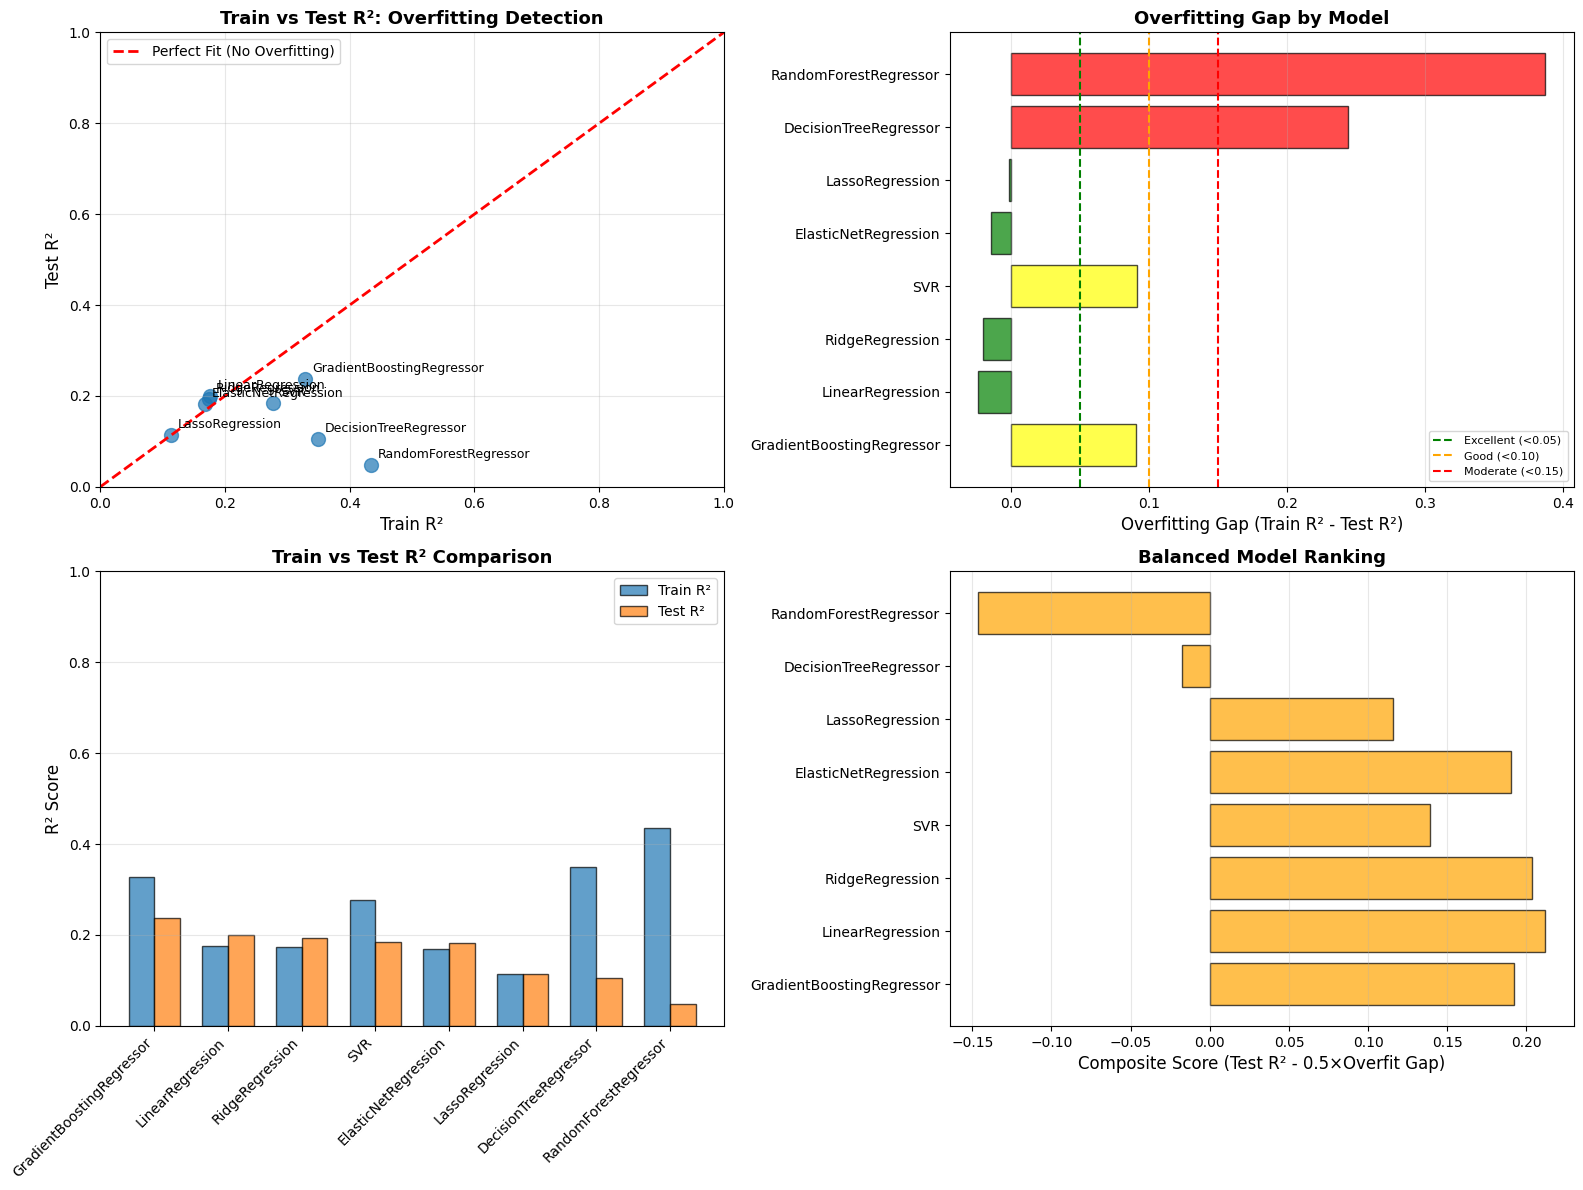


Composite Scores (Test R² - 0.5×Overfit Gap):
                    Model  Test_R2  Overfit_Gap  Composite_Score
         LinearRegression 0.200108    -0.023422         0.211819
          RidgeRegression 0.193584    -0.019899         0.203533
GradientBoostingRegressor 0.237665     0.090827         0.192252
     ElasticNetRegression 0.182831    -0.014542         0.190102
                      SVR 0.185159     0.091703         0.139307
          LassoRegression 0.115018    -0.001199         0.115618
    DecisionTreeRegressor 0.104876     0.244552        -0.017400
    RandomForestRegressor 0.047352     0.387199        -0.146247


In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Train vs Test R²
ax1 = axes[0, 0]
ax1.scatter(results_df['Train_R2'], results_df['Test_R2'], s=100, alpha=0.7)
for i, model in enumerate(results_df['Model']):
    ax1.annotate(model, 
                (results_df['Train_R2'].iloc[i], results_df['Test_R2'].iloc[i]),
                fontsize=9, xytext=(5, 5), textcoords='offset points')
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Fit (No Overfitting)', linewidth=2)
ax1.set_xlabel('Train R²', fontsize=12)
ax1.set_ylabel('Test R²', fontsize=12)
ax1.set_title('Train vs Test R²: Overfitting Detection', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot 2: Overfitting Gap
ax2 = axes[0, 1]
colors = results_df['Overfit_Gap'].apply(
    lambda x: 'green' if x < 0.05 else ('yellow' if x < 0.10 else ('orange' if x < 0.15 else 'red'))
)
ax2.barh(results_df['Model'], results_df['Overfit_Gap'], color=colors, alpha=0.7, edgecolor='black')
ax2.axvline(0.05, color='green', linestyle='--', linewidth=1.5, label='Excellent (<0.05)')
ax2.axvline(0.10, color='orange', linestyle='--', linewidth=1.5, label='Good (<0.10)')
ax2.axvline(0.15, color='red', linestyle='--', linewidth=1.5, label='Moderate (<0.15)')
ax2.set_xlabel('Overfitting Gap (Train R² - Test R²)', fontsize=12)
ax2.set_title('Overfitting Gap by Model', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=8)
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Model Performance Comparison
ax3 = axes[1, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax3.bar(x_pos - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.7, edgecolor='black')
ax3.bar(x_pos + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.7, edgecolor='black')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.set_ylabel('R² Score', fontsize=12)
ax3.set_title('Train vs Test R² Comparison', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 1])

# Plot 4: Composite Score (Test R² - Overfitting Penalty)
ax4 = axes[1, 1]
results_df['Composite_Score'] = results_df['Test_R2'] - (results_df['Overfit_Gap'] * 0.5)
colors_composite = results_df['Composite_Score'].apply(
    lambda x: 'green' if x > 0.7 else ('yellow' if x > 0.6 else 'orange')
)
ax4.barh(results_df['Model'], results_df['Composite_Score'], color=colors_composite, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Composite Score (Test R² - 0.5×Overfit Gap)', fontsize=12)
ax4.set_title('Balanced Model Ranking', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('trained_models/overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComposite Scores (Test R² - 0.5×Overfit Gap):")
print(results_df[['Model', 'Test_R2', 'Overfit_Gap', 'Composite_Score']].sort_values('Composite_Score', ascending=False).to_string(index=False))